In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd

from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils import resample
import xgboost as xgb 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import shap # Ling > !pip3 install shap works. conda or pip install shap does not work. 
from lime import lime_text # explain the model result

# packages for w2v
import spacy
import gensim
import nltk
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full
from gensim.models import word2vec

# plot packages for w2v-part
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
sns.set_style("darkgrid")

c:\Users\EQDIYCI\OneDrive - Allianz\TRAININGS\DATASCIENCE_ACADEMY\PROJECT\ds_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load saved data

In [2]:
from os.path import dirname

path = dirname(os.getcwd())
path

'c:\\Users\\EQDIYCI\\OneDrive - Allianz\\TRAININGS\\DATASCIENCE_ACADEMY\\PROJECT'

In [3]:
data_en = pd.read_pickle(path + "\data\processed\data_en3.pickle")

In [4]:
data_en.head()

marketplace  customer_id       review_id  product_id  product_parent   
0          US     12039526   RTIS3L2M1F5SM  B001CXYMFS       737716809  \
1          US      9636577   R1ZV7R40OLHKD  B00M920ND6       569686175   
2          US      2331478  R3BH071QLH8QMC  B0029CSOD2        98937668   
3          US     52495923  R127K9NTSXA2YH  B00GOOSV98        23143350   
4          US     14533949  R32ZWUXDJPW27Q  B00Y074JOM       821342511   

                                       product_title product_category   
0         Thrustmaster T-Flight Hotas X Flight Stick      Video Games  \
1  Tonsee 6 buttons Wireless Optical Silent Gamin...      Video Games   
2  Hidden Mysteries: Titanic Secrets of the Fatef...      Video Games   
3  GelTabz Performance Thumb Grips - PlayStation ...      Video Games   
4  Zero Suit Samus amiibo - Japan Import (Super S...      Video Games   

   star_rating  helpful_votes  total_votes vine verified_purchase   
0            5              0            0    N                 Y  \
1            5              0            0    N                 Y   
2            1              0            1    N                 Y   
3            3              0            0    N                 Y   
4            4              0            0    N                 Y   

                                     review_headline   
0  an amazing joystick. I especially love that yo...  \
1  Definitely a silent mouse... Not a single clic...   
2                                           One Star   
3                          good, but could be bettee   
4                                  Great but flawed.   

                                         review_body review_date language   
0  Used this for Elite Dangerous on my mac, an am...  2015-08-31       EN  \
1  Loved it,  I didn't even realise it was a gami...  2015-08-31       EN   
2     poor quality work and not as it is advertised.  2015-08-31       EN   
3  nice, but tend to slip away from stick in inte...  2015-08-31       EN   
4  Great amiibo, great for collecting. Quality ma...  2015-08-31       EN   

                                   processed_reviews   
0  use elit danger mac amaz joystick especi love ...  \
1  love even realis game mous type silent mous se...   
2                              poor qualiti advertis   
3  nice tend slip away stick intens hard press ga...   
4  great amiibo great collect qualiti materi desi...   

                                     lem_pos_ner_rem   
0  use_VERB this_PRON for_ADP on_ADP my_PRON mac_...  \
1  love_VERB it_PRON I_PRON do_AUX not_PART even_...   
2  poor_ADJ quality_NOUN work_NOUN and_CCONJ not_...   
3  nice_ADJ but_CCONJ tend_VERB to_PART slip_VERB...   
4  great_ADJ amiibo_NOUN great_ADJ for_ADP collec...   

                                head_lem_pos_ner_rem  
0  an_DET amazing_ADJ joystick_NOUN I_PRON especi...  
1  definitely_ADV a_DET silent_ADJ mouse_NOUN not...  
2                                          star_NOUN  
3    good_ADJ but_CCONJ could_AUX be_AUX bettee_VERB  
4                     great_ADJ but_CCONJ flawed_ADJ

# Undersampling to reduce calculation load and balance data

In [5]:
# need to convert column type to string, otherwise there is float in title --> cannot combine two columns head and review body
data_en['review_headline'] = data_en['review_headline'].astype(str)

In [6]:
data_en["lem_comb"] =  data_en[["lem_pos_ner_rem", "head_lem_pos_ner_rem"]].apply(lambda x: x["head_lem_pos_ner_rem"] + " " + x["lem_pos_ner_rem"] , axis=1)
data_en["head_body"] = data_en[["review_headline", "processed_reviews"]].apply(lambda x: x["review_headline"] + " " + x["processed_reviews"] , axis=1)

In [7]:
data_en[['lem_comb', 'head_body']].sample(5)

lem_comb   
1146618  need_VERB more_ADJ replay_NOUN value_NOUN its_...  \
1687244   I_PRON simply_ADV speachless_PROPN BR_PROPN i...   
1418340  will_AUX not_PART even_ADV run_VERB after_ADP ...   
1255893  fun_NOUN the_DET game_NOUN be_AUX so_ADV much_...   
1323944  just_ADV a_DET poor_ADJ rehash_NOUN hard_ADJ t...   

                                                 head_body  
1146618  needs more replay value awesom expans dynasti ...  
1687244  Speachless simpli speachless br like first dra...  
1418340  Won't even run near week tri go give one progr...  
1255893  fun game much fun pokemon look ok love music t...  
1323944  Just a poor rehash hard say good thing game go...

In [8]:
# using combined headline and reviewbody for training
X = data_en['lem_comb']  
X_wo_pos = data_en['head_body']
y = data_en["star_rating"]

In [9]:
print(X.shape)
print(X_wo_pos.shape)

(1753198,)
(1753198,)


In [10]:
X.head()

0    an_DET amazing_ADJ joystick_NOUN I_PRON especi...
1    definitely_ADV a_DET silent_ADJ mouse_NOUN not...
2    star_NOUN poor_ADJ quality_NOUN work_NOUN and_...
3    good_ADJ but_CCONJ could_AUX be_AUX bettee_VER...
4    great_ADJ but_CCONJ flawed_ADJ great_ADJ amiib...
Name: lem_comb, dtype: object

In [11]:
X_wo_pos.head()

0    an amazing joystick. I especially love that yo...
1    Definitely a silent mouse... Not a single clic...
2                       One Star poor qualiti advertis
3    good, but could be bettee nice tend slip away ...
4    Great but flawed. great amiibo great collect q...
Name: head_body, dtype: object

In [12]:
y.head()

0    5
1    5
2    1
3    3
4    4
Name: star_rating, dtype: int64

## reencoding > 3 Classes positive, negative and neutral

In [13]:
def recode_labels(in_arrary):
    '''
    reencode rating: 1, 2 --> 0 as negative. 3 --> 1 as neutral, 4, 5 --> 2 as positive
    '''
    rec = [0 if x in [1, 2] else (1 if x == 3 else 2) for x in in_arrary]
    return(np.array(rec))

print(np.unique(y))
y = recode_labels(y)
print(np.unique(y))

[1 2 3 4 5]
[0 1 2]


In [14]:
# undersample the data
rs = [resample(X[y == sr], y[y == sr], X_wo_pos[y == sr], replace=False, 
    n_samples=int(np.floor(1*(X_wo_pos[y == 1].shape[0]))), random_state=123) for sr in [0, 1, 2]]

In [15]:
rs[1][0]

987328     not_PART as_ADV good_ADJ as_ADP the_DET this_D...
256685                                     star_NOUN ok_INTJ
1591348     Vs_PROPN Capcom_PROPN Chaos_PROPN Live_PROPN ...
750571     just_ADV I_PRON know_VERB this_PRON be_AUX a_D...
56375      not_PART a_DET favorite_NOUN it_PRON ok_ADJ no...
                                 ...                        
1716225    a_DET list_NOUN of_ADP pro_NOUN and_CCONJ con_...
1455350    Falls_PROPN short_ADJ the_DET storyline_NOUN i...
265960     I_PRON have_VERB consol_NOUN so_SCONJ I_PRON c...
422430     okay_INTJ but_CCONJ not_PART amazing_ADJ I_PRO...
235198     episode_NOUN I_PRON this_DET game_NOUN only_AD...
Name: lem_comb, Length: 152228, dtype: object

In [16]:
rs[1][2]

987328     Not as good as the first one game frustrat tim...
256685                                        Three Stars ok
1591348    Polish, shmallish snk vs capcom chao live game...
750571     Just O.K. know popular game one time style fou...
56375                             not a favorite. ok favorit
                                 ...                        
1716225    A list of pros and cons for what is overall a ...
1455350    Falls short storylin game promis way game led ...
265960     i have four gigabite consol so i cant play it ...
422430     Okay but not amazing casual gamer alway like g...
235198     Only 5 episodes love game video game actual en...
Name: head_body, Length: 152228, dtype: object

In [17]:
# X_list = [rs[r][0] for r in range(5)] # with postagging
X_list = [rs[r][2] for r in range(3)] # without postagging
y_list = [rs[r][1] for r in range(3)]


X_us = np.hstack(X_list)
y_us = np.hstack(y_list)

In [18]:
print(X_us.shape)
print(y_us.shape)

(456684,)
(456684,)


In [19]:
X_us

array(['you have 4 choices list four choic would say dont buy target wasent satisfi get much better choic repeat dont buy target',
       'Meh stellar graphic game play ok repetit open world explor bore first hour',
       'Freezes up game good troubl freez middl game wish could return',
       ...,
       'Still a great game took sever year break comput game recent bought powerbook new machin decid tri starcraft battlechest cheap even year releas starcraft still great game three race terran protoss zerg differ play style like three game one storylin great job keep gameplay fresh otherwis would anoth game build forc rush br recommend battlechest anoth reason two hint book come bundl school may time burn play scenario two three time get right hold full time job usual play figur gimmick scenario check hint book ca wast lot time get next mission told storylin good goe doubli marri starcraft player unless spend qualiti time kid play game jeopard marraig spend hour front comput tri finish g

# Function definitions

In [20]:
#from sklearn.base import BaseEstimator, TransformerMixin
# Comment Ling: is this function in use?
class ModifiedLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return y.todense()-1

    def transform(self, y, *args, **kwargs):
        return y.todense()-1

In [21]:
def assess_on_val(clf, X_val_vectorized, y_val):
    '''
    plot the assessment of the prediction result
    '''
    print("Start predicting")
    predicted = clf.predict(X_val_vectorized)
    print("Finished predicting")
    total_accuracy = metrics.accuracy_score(predicted, y_val)

    accuracy_by_rating_class = {rc : metrics.accuracy_score(predicted[y_val==rc], y_val[y_val==rc]) for rc in np.unique(y_val)}
    accuracy_by_rating_class = pd.DataFrame.from_dict(accuracy_by_rating_class, orient="index")

    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(131)
    accuracy_by_rating_class.sort_index().plot(kind = "bar", ax = ax)
    ax.set_title("Accuracy per  \nrating class")
    ax.axhline(y = total_accuracy, color ='r', linestyle = '--')
    ax.get_legend().remove()
    ax.set_ylim(0,1)

    ax2 = fig.add_subplot(132)
    pd.DataFrame({"star_rating": predicted}).value_counts(normalize=1).reset_index().set_index("star_rating").sort_index().plot(kind="bar", ax=ax2)
    ax2.set_title("Percentage of \n predicted rating class")
    ax2.get_legend().remove()
    ax2.set_ylim(0,1)

    ax3 = fig.add_subplot(133)
    pd.DataFrame({"star_rating": y_val}).value_counts(normalize=1).reset_index().set_index("star_rating").sort_index().plot(kind="bar", ax=ax3)
    ax3.set_title("Percentage of actual \n rating classes in val")
    ax3.get_legend().remove()
    ax3.set_ylim(0,1)    
    fig.suptitle(str(clf._final_estimator), y=1.1)
    
    print("Global accuracy: " + str(total_accuracy))
    return fig

In [22]:
def model_interpretation(x_val, y_val):
    '''
    print out the classification report of the prediction result
    '''
    print(classification_report(y_val, pipeline.predict(X_val)))

    confusion_matrix = pd.crosstab(y_val, pipeline.predict(X_val), rownames=['Actual class'], colnames=['Predicted class'], normalize=1)
    confusion_matrix

In [23]:
## Plot roc
def plot_roc(X_test, y_test, model):
    '''
    create plot roc
    '''
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    predicted_prob  = model.predict_proba(X_test)

    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                            predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                metrics.auc(fpr, tpr))
                )
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
            xlabel='False Positive Rate', 
            ylabel="True Positive Rate (Recall)", 
            title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)
    
## Plot precision-recall curve
def plot_precision_recall_curve(X_test, y_test, model):
    '''
    create precision and recall curve
    '''
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    predicted_prob  = model.predict_proba(X_test)

    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                    y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                    metrics.auc(recall, precision))
                )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
            ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)


In [24]:
def explain_obv(y_train, X_val, y_val, model, i, n_features):
    '''
    explain the selected observation with the model
    '''
    ## select observation
    txt_instance = X_val[i]
    ## check true value and predicted value
    print("True:", y_val[i], "--> Pred:", model.predict(X_val)[i], "| Prob:", round(np.max(model.predict_proba(X_val)[i]),2))

    ## show explanation
    explainer = lime_text.LimeTextExplainer(class_names= np.unique(y_train))
    explained = explainer.explain_instance(txt_instance, model.predict_proba, num_features=n_features)
    explained.show_in_notebook(text=txt_instance, predict_proba=False)

# Split data into train, test and val

In [25]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X_us, y_us, test_size= 0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, random_state=42)

# Illustrate class imbalance

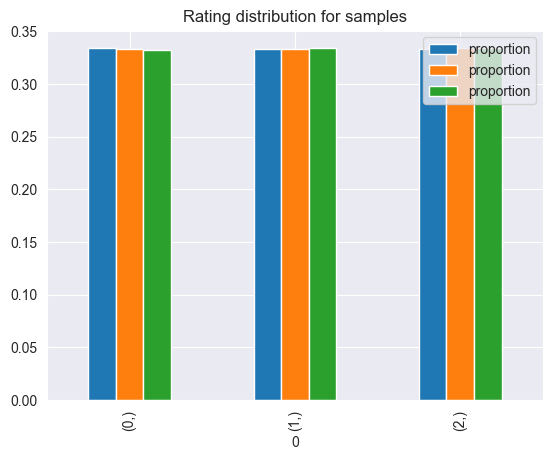

In [26]:
pd.concat([pd.DataFrame(x).value_counts(normalize=1) for x in [y_train, y_val, y_test]], axis=1).rename({0:"train", 1:"val", 2:"test"}, axis=1).plot(kind="bar")
plt.title("Rating distribution for samples");

# Pipeline: logistic regression and xbg


In [27]:
#help(LabelEncoder)

In [28]:
def selpc_fun(X,y):
        f = X.mean(axis=0)
        f = np.asarray(f).ravel()
        return f

def selpc_fun_inv(X,y):
        f = -1.0*X.mean(axis=0)
        f = np.asarray(f).ravel()
        return f

# Parameters
lr_params = dict(C=0.5, max_iter=1000)#, multi_class = "multinomial")
# lr_params = dict(multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1) 
vectorizer_params = dict(ngram_range=(1, 3), min_df=0.0001, max_df=0.35-0.25)#, max_features=10000) # 0.001 performs good and reduces runtime
tfidf_params = dict(norm='l2')
varth_params = dict(threshold=0.00005/100)
percth_params = dict(score_func= selpc_fun, percentile = 95)

# Supervised Pipeline
# pipeline for xgb
clf_xgb = xgb.XGBClassifier(
                base_score=0.2, booster='gbtree', colsample_bylevel=0.8,
                colsample_bynode=1, colsample_bytree=0.9, eval_metric='mlogloss',
                gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.05,
                max_delta_step=0, max_depth=25, min_child_weight=1,# missing=nan,
                monotone_constraints='()', n_estimators=25, n_jobs=12,
                num_parallel_tree=1, objective='multi:softprob', random_state=0,
                reg_alpha=0.3, reg_lambda=1, scale_pos_weight=None, subsample=1,
                tree_method='exact', #use_label_encoder=True,
                validate_parameters=1, verbosity=None
        )

xgb_steps = [ ("vect", CountVectorizer(**vectorizer_params)),
        ("tfidf", TfidfTransformer(**tfidf_params)),
        #("le", ModifiedLabelEncoder()),
        #("percth", SelectPercentile(**percth_params)),
        #("varth", VarianceThreshold(**varth_params)),
        ("clf", clf_xgb)]

# pipeline for logistic regression 
lr_steps = [ ("vect", CountVectorizer(**vectorizer_params)),
        ("tfidf", TfidfTransformer(**tfidf_params)),
        #("percth", SelectPercentile(**percth_params)),
        #("varth", VarianceThreshold(**varth_params)),
        ("clf", LogisticRegression(**lr_params))]

# pipeline for logistic regression for word2vec
lr_steps_w2v = [("clf", LogisticRegression(**lr_params))] 

## logistic regression

### prediction

In [29]:
%%time
pipeline = Pipeline(lr_steps)
pipeline.fit(X_train, y_train)
print("Training_Score: ", pipeline.score(X_train, y_train), " / Val. Score: ", pipeline.score(X_val, y_val))

# multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1


# C=0.5, max_iter=1000
# Training_Score:  0.8264807853727966  / Val. Score:  0.776811065289588
# CPU times: total: 3min 50s

Training_Score:  0.8264807853727966  / Val. Score:  0.776811065289588
CPU times: total: 3min 50s
Wall time: 3min 53s


### Interpretation

Start predicting
Finished predicting
Global accuracy: 0.07784387431115652


Predicted class       0         1         2
Actual class                               
0                0.2029  0.827533  0.969099
2                0.7971  0.172467  0.030901

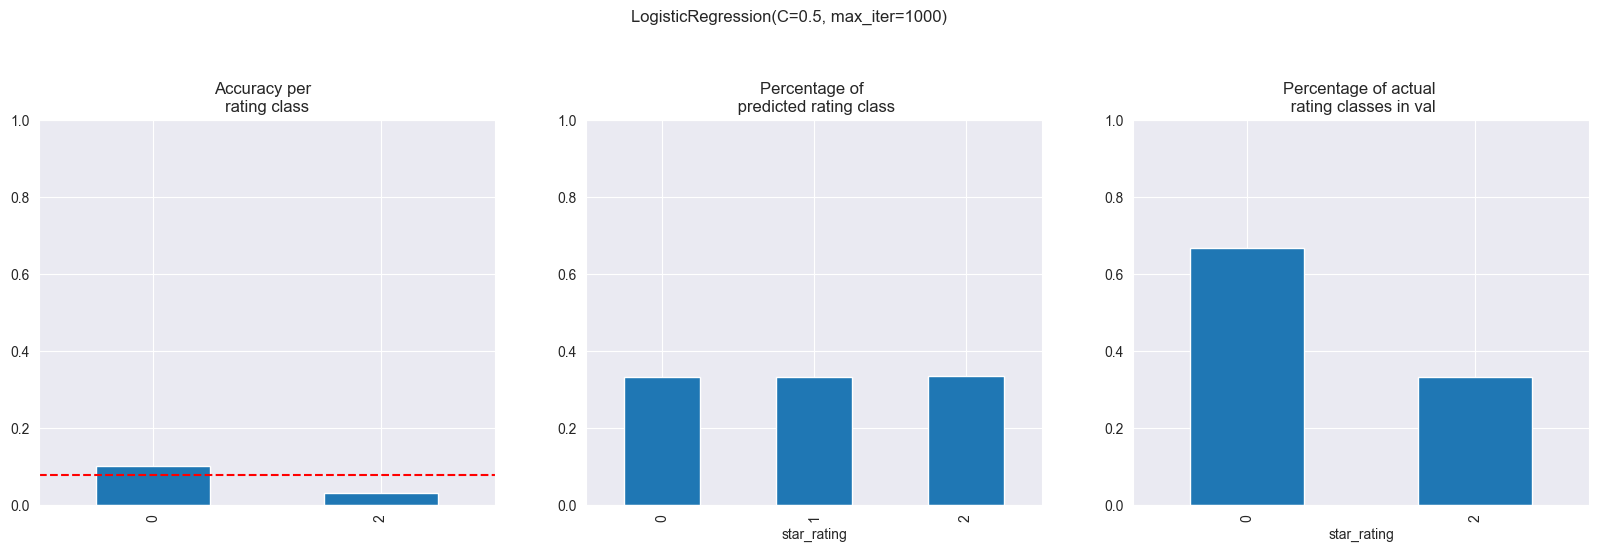

In [30]:
assess_on_val(pipeline, X_val, recode_labels(y_val));
confusion_matrix = pd.crosstab(
        recode_labels(y_val), pipeline.predict(X_val), 
        rownames=['Actual class'], colnames=['Predicted class'], normalize=1
    )

confusion_matrix

# lr_params = dict(C=0.5, max_iter=1000)
# Global accuracy: 0.07784387431115652
# Predicted class	0	1	2
# Actual class			
# 0	0.2029	0.827533	0.969099
# 2	0.7971	0.172467	0.030901

# lr_params = dict(multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1) 


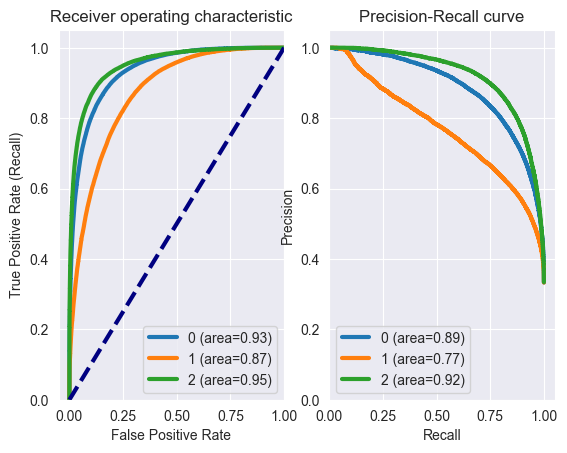

In [31]:

fig, ax = plt.subplots(nrows=1, ncols=2)

plot_roc(X_val ,y_val, pipeline)
plot_precision_recall_curve(X_val, y_val, pipeline)

plt.show()

In [32]:
pd.DataFrame(pipeline.predict(X_val)).value_counts()

# lr_params = dict(C=0.5, max_iter=1000)
# 2    45824
# 1    45597
# 0    45584
# Name: count, dtype: int64

# lr_params = dict(multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1) 
# 0    86184
# 2    54697

2    45824
1    45597
0    45584
Name: count, dtype: int64

In [33]:
print(classification_report(y_val, pipeline.predict(X_val)))

# lr_params = dict(C=0.5, max_iter=1000)
#               precision    recall  f1-score   support

#            0       0.80      0.80      0.80     45615
#            1       0.70      0.70      0.70     45606
#            2       0.84      0.84      0.84     45784

#     accuracy                           0.78    137005
#    macro avg       0.78      0.78      0.78    137005
# weighted avg       0.78      0.78      0.78    137005

# lr_params = dict(multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1) 




              precision    recall  f1-score   support

           0       0.80      0.80      0.80     45615
           1       0.70      0.70      0.70     45606
           2       0.84      0.84      0.84     45784

    accuracy                           0.78    137005
   macro avg       0.78      0.78      0.78    137005
weighted avg       0.78      0.78      0.78    137005



In [34]:
# dir(pipeline)

In [35]:
# pipeline.get_params()

In [36]:
# dir(pipeline["tfidf"])


In [37]:
# dir(pipeline["vect"])

#### Strongest and weakest features in prediction

In [38]:
tok_coef = pd.DataFrame(
    {
        "token": pipeline["vect"].get_feature_names_out()
        , "coef_neg": pipeline["clf"].coef_[0,:]
        , "coef_neu": pipeline["clf"].coef_[1,:]
        , "coef_pos": pipeline["clf"].coef_[2,:]
        # , "coef_4": pipeline["clf"].coef_[3,:]
        # , "coef_5": pipeline["clf"].coef_[4,:]
    }
)

tok_coef.head()

token  coef_neg  coef_neu  coef_pos
0    00  0.539927 -0.087825 -0.452103
1   007  0.083186 -0.119538  0.036353
2    07  0.233154  0.050356 -0.283509
3    08 -0.459791  0.537259 -0.077469
4    09 -0.306862  0.132996  0.173866

In [39]:
tok_coef["delta"] = tok_coef["coef_pos"] - tok_coef["coef_neg"]
tok_coef["abs_delta"] = np.abs(tok_coef["delta"]) 

num = 40

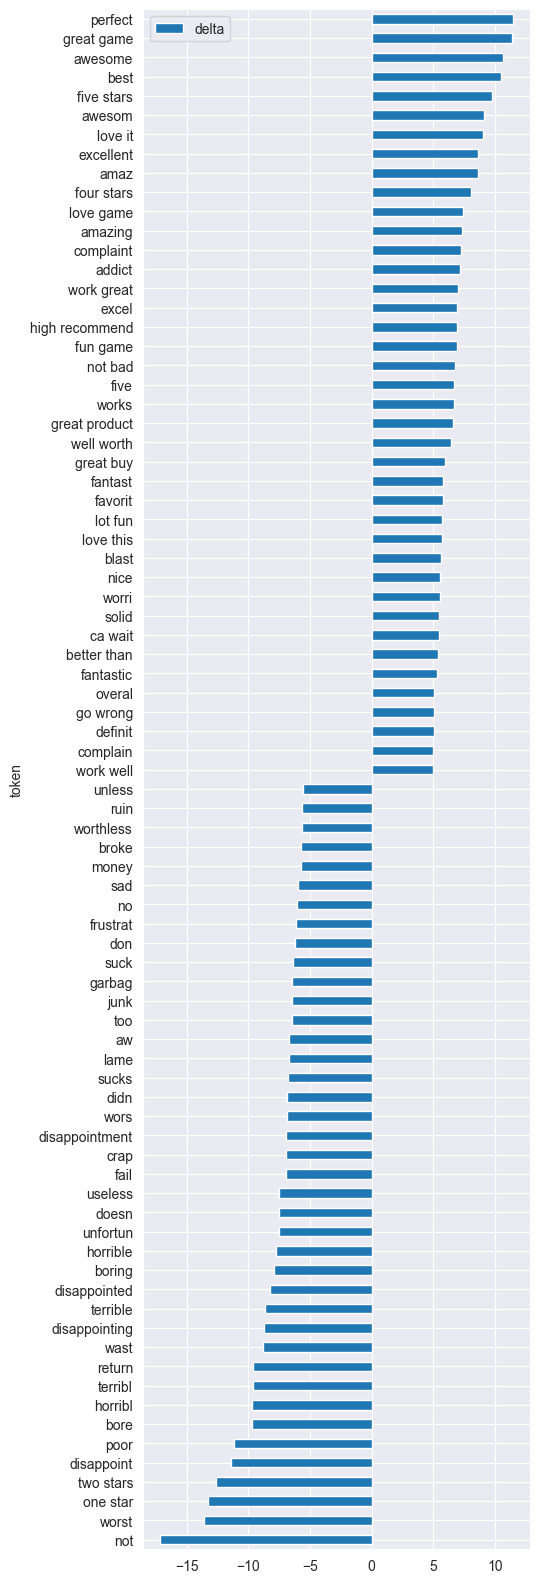

In [40]:
# strongest words for positive (rating 5&4) and negative (rating 1&2) predictions
strongest_words = pd.concat(
        [tok_coef.sort_values("delta").head(num), 
        tok_coef.sort_values("delta").tail(num)]
    )[["token", "delta"]].set_index("token").plot(kind="barh", figsize=(5,20))


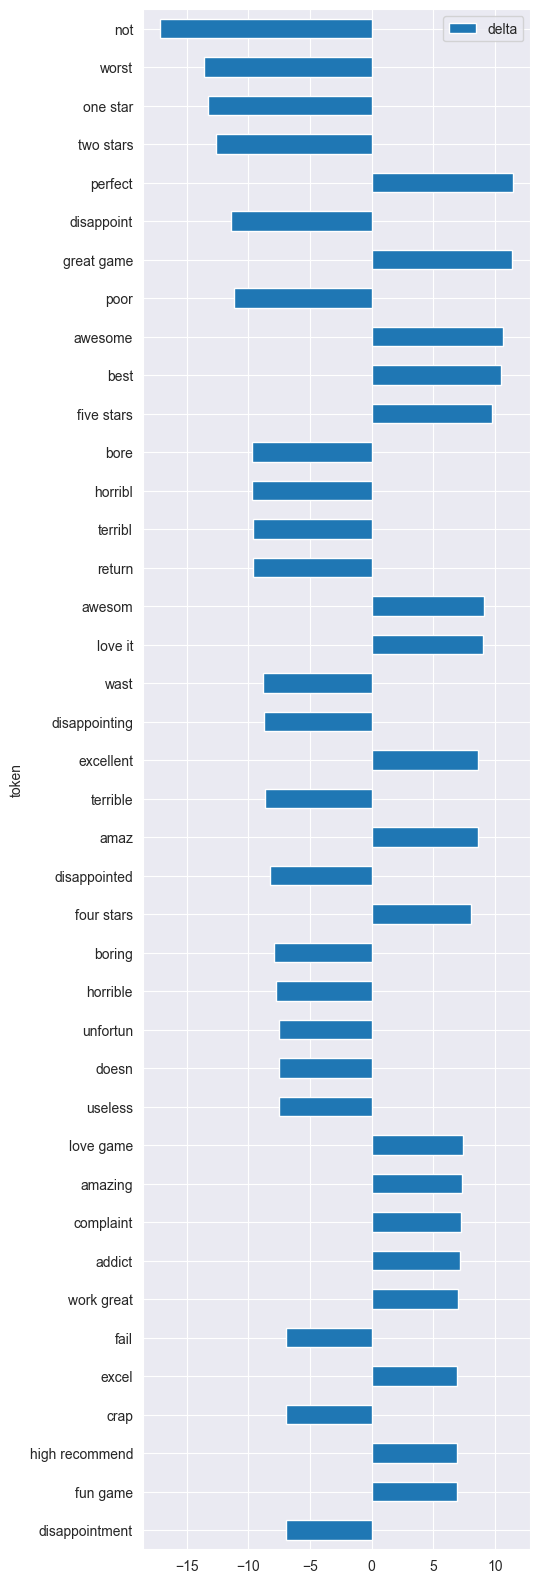

In [41]:
# strongest words (mixing positive and negative ratings)
strongest_words2 = tok_coef.sort_values("abs_delta").tail(num)[
    ["token", "delta"]].set_index("token").plot(kind="barh", figsize=(5,20))

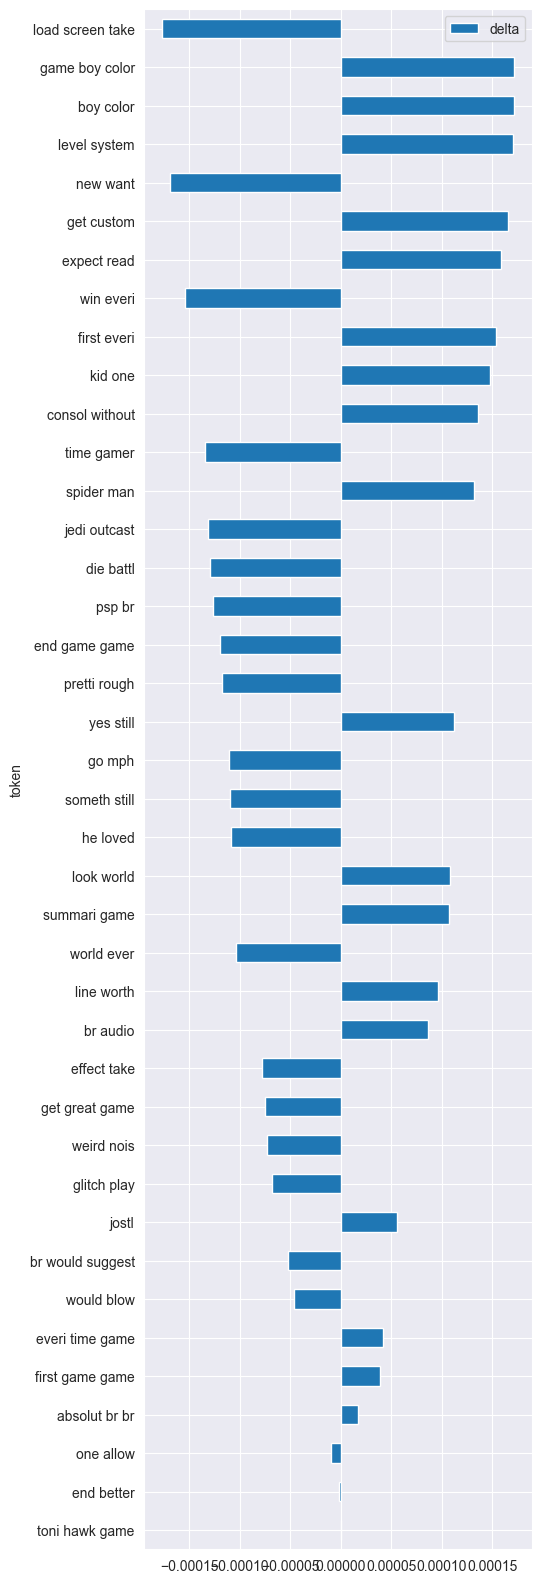

In [42]:
# weakest words (mixing positive and negative ratings)
weakest_words = tok_coef.sort_values("abs_delta").head(40)[
    ["token", "delta"]].set_index("token").plot(kind="barh", figsize=(5,20))

<Axes: >

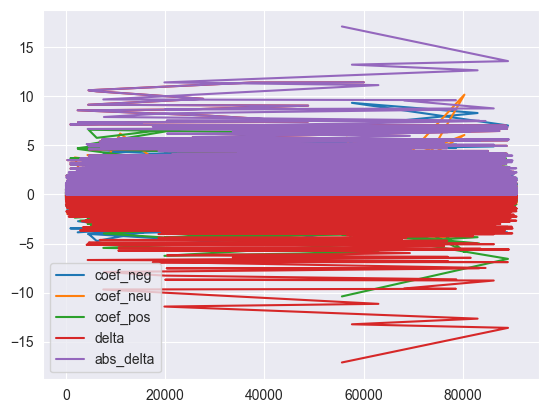

In [43]:
# does this graph make sense?
tok_coef.sort_values("delta").plot()

In [44]:
pipeline["vect"].get_feature_names_out().shape
pipeline["clf"].coef_[0,:].shape

(90830,)

In [45]:
pipeline["tfidf"].get_feature_names_out()

array(['x0', 'x1', 'x2', ..., 'x90827', 'x90828', 'x90829'], dtype=object)

In [46]:
 print(len(pipeline["tfidf"].get_feature_names_out()), " / ",len(pipeline["vect"].get_feature_names_out()))

90830  /  90830


#### SHAP interpretation

In [47]:
#https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Using%20custom%20functions%20and%20tokenizers.html
def f(X):    
    val = pipeline.predict(X)
    return val

In [48]:
masker = shap.maskers.Text(r"\W") # this will create a basic whitespace tokenizer
explainer = shap.Explainer(f, masker)#, output_names=labels)

In [49]:
true_pred= pd.DataFrame({"true": y_val, "pred": f(X_val)})

In [50]:
true_pred["delta"] = abs(true_pred.true -true_pred.pred)

In [51]:
true_pred.value_counts("delta")
# delta
# 0    106427
# 1     27675
# 2      2903
# Name: count, dtype: int64

delta
0    106427
1     27675
2      2903
Name: count, dtype: int64

#### Explain worst predictions

In [52]:
# explain worst 7 explanation
shap_values_worst = explainer(X_val[true_pred.sort_values("delta", ascending=False).head(7).index])

In [53]:
X_val[true_pred.sort_values("delta", ascending=False).head(7).index]


array(['My grandson can only play a few levels of his favorite game game stick paus spot grandson play level favorit game',
       'Thank goodness GTA came out... got brother play week level put say worth money wait said would rather play pokemon touch game',
       'what the? final fantasi fan play everi singl one tend take time readi play anoth final fantasi game went got realli happi like whole battl point click walk like snail tell dude walk like snail die thing tri though still rather go dmv',
       'No compatibility issues here. window game fine machin color mess go task manag end explor',
       'I bouth this for my dsi xl and as it ... bouth dsi xl said case think fit xl fit husbend ds',
       'black ops 2 black op cool game target way sout doein hell wood buy game intel target updat black op game lam like lest black op game befor thay need tesd game befor thay res game er',
       'How can you NOT buy this? game excel gameplay way control feel work br br plus buck last check

In [54]:
true_pred.sort_values("delta", ascending=False).head(7)

true  pred  delta
99599      0     2      2
125852     0     2      2
104038     0     2      2
68500      2     0      2
68488      0     2      2
42317      0     2      2
134212     2     0      2

In [55]:
shap.plots.text(shap_values_worst)

#### Explain best precditions

In [56]:
shap_values_best = explainer(X_val[true_pred.sort_values("delta", ascending=False).tail(7).index])

In [57]:
shap.plots.text(shap_values_worst)

#### Explain example observation

In [58]:
explain_obv(y_train, X_val, y_val, pipeline, i=10, n_features=10)

True: 1 --> Pred: 2 | Prob: 0.61


In [59]:
explain_obv(y_train, X_val, y_val, pipeline, i=100, n_features=10)

True: 0 --> Pred: 1 | Prob: 0.72


## XGB (results tbd)

In [60]:
%%time 
# pipeline = Pipeline(xgb_steps)
# pipeline.fit(X_train, y_train-1)
# print("Training_Score: ", pipeline.score(X_train, y_train-1), " / Val. Score: ", pipeline.score(X_val, y_val-1))

CPU times: total: 0 ns
Wall time: 0 ns


In [61]:
#LR Result: Training_Score:  0.6106515049882348  / Val. Score:  0.5436077256691818
#XGB: Training_Score:  0.7842903433027048  / Val. Score:  0.4886109553452914

#LR 0.25*sample Training_Score:  0.6574957410562181  / Val. Score:  0.5226007950028393
#XGB 0.7581061896649631  / Val. Score:  0.43878478137421917
#Weaker parameters: 0.40954003407155026  / Val. Score:  0.38225440090857465

#Training_Score:  0.5758446905167518  / Val. Score:  0.49630891538898353

# Tuned df_min and df_max, as well of ngram number

# 250K obs, headline and body: Training_Score:  0.7014157288217403  / Val. Score:  0.5736543607725669
# same only body: Training_Score:  0.6837767911329734  / Val. Score:  0.5496553829118191
# same only head: Training_Score:  0.49153721389962485  / Val. Score:  0.45453964693606663
# as above, all, C = 0.95: Training_Score:  0.7480222740388198  / Val. Score:  0.5698568295227887
# C =0.15: Training_Score:  0.63208086228497  / Val. Score:  0.5675783107729219
# C = 0.05: Training_Score:  0.5883668189222857  / Val. Score:  0.5544324642783626b

# Word2Vec

In [62]:
# Word2Vec is not a single algorithm but a combination of two techniques – CBOW (Continuous bag of words) and Skip-gram model. 
# Both of these are shallow neural networks which map word(s) to the target variable which is also a word(s). 
# Both of these techniques learn weights which act as word vector representations.

In [63]:
%%time
# wordpunct_tokenize will split pretty much at all special symbols and treat them as separate units. word_tokenize on the other hand keeps things like 're together.
# tokenization of reviews with postagging
tokenizer = nltk.WordPunctTokenizer() # extract the tokens from string of words or sentences in the form of Alphabetic and Non-Alphabetic character

X_us_tok = [tokenizer.tokenize(review) for review in X_us]
print ("Tokenize the first review:")
print (X_us_tok[0])

Tokenize the first review:
['you', 'have', '4', 'choices', 'list', 'four', 'choic', 'would', 'say', 'dont', 'buy', 'target', 'wasent', 'satisfi', 'get', 'much', 'better', 'choic', 'repeat', 'dont', 'buy', 'target']
CPU times: total: 14.6 s
Wall time: 15.1 s


## self-trained model

### load model without posttag

In [64]:
# load the pre-trained model
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load(path+'/data/trained_model/word2vec_selftrained_wo_pos_0505.model', mmap='r')

### create feature matrix

In [65]:
# Create feature vectors
def create_features(review_tokens, model):
    num_features = model.vector_size
    features = np.zeros((len(review_tokens), num_features), dtype="float32")
    for i, tokens in enumerate(review_tokens):
        for token in tokens:
            if token in model.wv.key_to_index:
                features[i] += model.wv.get_vector(token)
    return features

In [66]:
%%time
# create features. Output of create_features is array and needs to be converted to dataframe
X_train_features = pd.DataFrame(create_features(X_train, w2v_model))
X_test_features = pd.DataFrame(create_features(X_test, w2v_model))
X_val_features = pd.DataFrame(create_features(X_val, w2v_model))

# save the feature vector
X_train_features.to_csv(path + "/word2vec_selftrained_wo_pos_X_train_features_0512.csv", index=False)
X_test_features.to_csv(path + "/word2vec_selftrained_wo_pos_X_test_features_0512.csv", index=False)
X_val_features.to_csv(path + "/word2vec_selftrained_wo_pos_X_val_features_0512.csv", index=False)

CPU times: total: 14min 6s
Wall time: 14min 23s


In [67]:
# X_train_features = pd.read_csv(path + "/data/processed/word2vec_selftrained_w_pos_X_train_features_0505.csv")
# X_test_features = pd.read_csv(path + "/data/processed/word2vec_selftrained_w_pos_X_test_features_0505.csv")
# X_val_features = pd.read_csv(path + "/data/processed/word2vec_selftrained_w_pos_X_val_features_0505.csv")

In [68]:
X_train_features.head()

0          1          2         3          4          5          6     
0  -1.137014  -7.211507   1.585597  0.866691   3.415419   2.925892 -10.327643  \
1  10.573014 -27.215986  17.975309  8.877920   7.418624  18.188635 -72.991379   
2   1.730554  -3.152636   0.888860  0.018458   1.483867   3.152787 -10.411339   
3   7.832641 -24.661102  22.061991 -3.813813  12.443146  23.393017 -74.652489   
4  -0.863322  -3.346267   0.112590  0.741635   0.458595   1.494686  -4.963604   

         7          8          9    ...        290        291        292   
0  -3.583979   2.140658  -0.149812  ... -13.186059  -7.521183   5.794250  \
1 -22.449133  32.382832  20.427414  ... -89.017570 -52.566921  40.805012   
2  -3.707180   3.630802   4.699924  ... -11.734815  -6.690115   6.552739   
3 -27.753187  33.021133  25.135967  ... -82.304398 -50.583496  39.458218   
4  -1.065129   1.218443   1.253278  ...  -6.160396  -5.110321   5.009218   

         293        294        295        296        297        298   
0   6.987654  -5.692821  14.469648  -5.009245 -10.922405  11.347378  \
1  54.765938 -51.913841  62.875332 -34.830395 -80.190880  68.667122   
2   5.062555  -7.316061  11.065439  -3.660135 -10.627117   9.779781   
3  34.322124 -42.357090  65.244812 -20.188147 -74.267296  66.435829   
4   4.732285  -3.299670   7.877720  -2.605976  -7.008622   6.735634   

          299  
0   15.023041  
1  116.698715  
2   16.452883  
3  110.976410  
4    8.478447  

[5 rows x 300 columns]

### logistic regression

In [69]:
%%time
pipeline = Pipeline(lr_steps_w2v)
pipeline.fit(X_train_features, y_train)
print("Training_Score: ", pipeline.score(X_train_features, y_train), " / Val. Score: ", pipeline.score(X_val_features, y_val))

# Result of parameters multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1

# Result of parameters C=0.5, max_iter=1000
# lbfgs failed to converge (status=1):
# Training_Score:  0.5330973322141528  / Val. Score:  0.5365862559760592

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Training_Score:  0.5330973322141528  / Val. Score:  0.5365862559760592
CPU times: total: 8min 54s
Wall time: 3min 54s


Start predicting
Finished predicting
Global accuracy: 0.22802087515054195


Predicted class         0         1         2
Actual class                                 
0                0.472601  0.712253  0.809523
2                0.527399  0.287747  0.190477

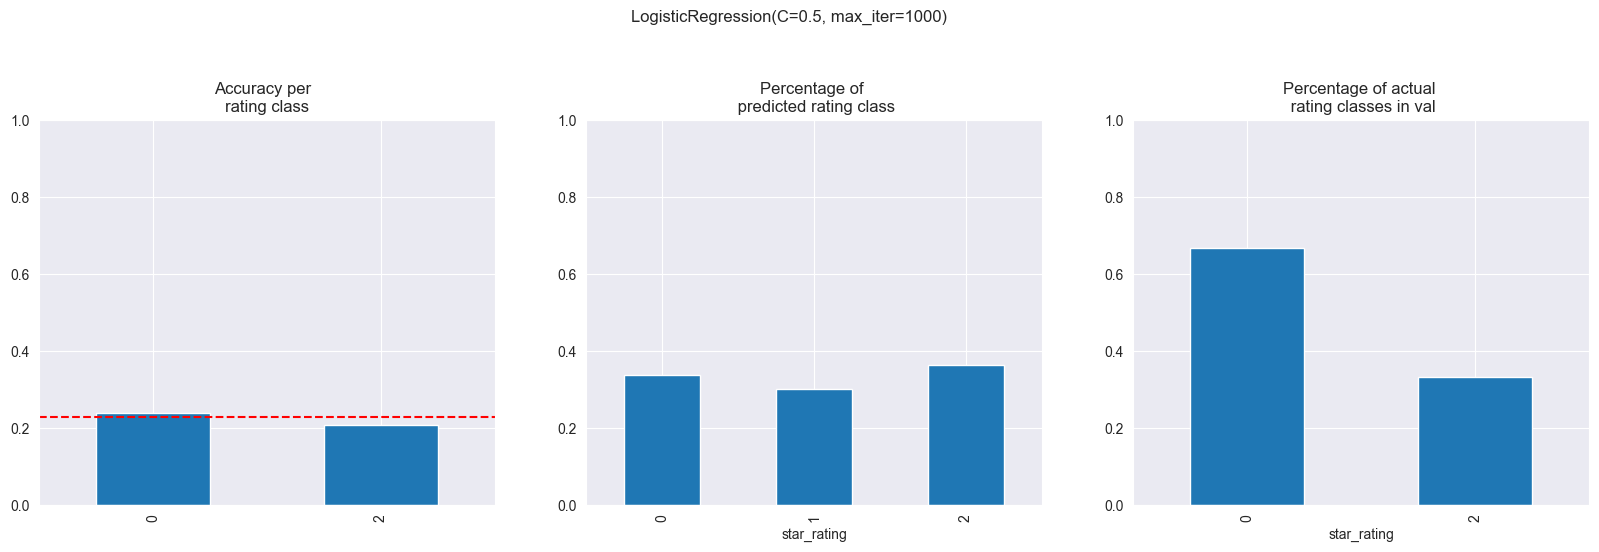

In [70]:
assess_on_val(pipeline, X_val_features, recode_labels(y_val));
confusion_matrix = pd.crosstab(
        recode_labels(y_val), pipeline.predict(X_val_features), 
        rownames=['Actual class'], colnames=['Predicted class'], normalize=1
    )

confusion_matrix
# lr_params = dict(C=0.5, max_iter=1000)
# Global accuracy: 0.22802087515054195
# Predicted class	0	1	2
# Actual class			
# 0	0.472601	0.712253	0.809523
# 2	0.527399	0.287747	0.190477

# lr_params = dict(multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1) 


In [71]:
pd.DataFrame(pipeline.predict(X_val_features)).value_counts()

# lr_params = dict(C=0.5, max_iter=1000)
# 2    49775
# 0    46041
# 1    41189

# lr_params = dict(multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1) 


2    49775
0    46041
1    41189
Name: count, dtype: int64

In [72]:
print(classification_report(y_val, pipeline.predict(X_val_features)))

# lr_params = dict(C=0.5, max_iter=1000)
# precision    recall  f1-score   support
#               precision    recall  f1-score   support

#            0       0.53      0.53      0.53     45615
#            1       0.51      0.46      0.48     45606
#            2       0.57      0.62      0.59     45784

#     accuracy                           0.54    137005
#    macro avg       0.53      0.54      0.53    137005
# weighted avg       0.53      0.54      0.53    137005

# lr_params = dict(multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1) 

              precision    recall  f1-score   support

           0       0.53      0.53      0.53     45615
           1       0.51      0.46      0.48     45606
           2       0.57      0.62      0.59     45784

    accuracy                           0.54    137005
   macro avg       0.53      0.54      0.53    137005
weighted avg       0.53      0.54      0.53    137005



In [73]:
# the result of w2v works much worse compared to tfidf / count-vectorizer
# probably because the data which is used for training is too small
# reference: https://datascience.stackexchange.com/questions/19160/why-word2vec-performs-much-worst-than-both-countvectorizer-and-tfidfvectorizer

### logistic regression with features from tfidf

In [75]:
nlp  = spacy.load('en_core_web_md')

In [76]:
X_us_df = pd.DataFrame(X_us)

In [ ]:
# X_us_nlp = pd.DataFrame(X_us)[0].apply(nlp) # 158 min slow

In [ ]:
# X_us_nlp.to_csv(path + "/data/processed/X_us_nlp_3Classes_wo_pt_0512.csv")

In [77]:
# X_us_nlp = pd.read_csv(path + "/data/processed/X_us_nlp_3Classes_wo_pt_0512.csv")

In [117]:
def lemmatize_doc(doc):
    return [ t.lemma_ for t in doc]

In [118]:
def prepare_w2v_tfidf_vec(X_us_nlp):
    docs = [lemmatize_doc(nlp(doc)) for doc in X_us]

    docs_dict = Dictionary(docs)
    docs_dict.filter_extremes(no_below=20, no_above=0.2)
    docs_dict.compactify()

    # create a bag-of-words representation of each document, build the TF-IDF model, and compute the TF-IDF vector for each document.
    docs_corpus = [docs_dict.doc2bow(doc) for doc in docs]
    model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)
    docs_tfidf  = model_tfidf[docs_corpus]
    docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])

    #  use spaCy to get the 300 dimensional Glove embedding vector for each TF-IDF term
    tfidf_emb_vecs = np.vstack([nlp(docs_dict[i]).vector for i in range(len(docs_dict))])

    #  To get a TF-IDF weighted Glove vector summary of each document, we just need to matrix multiply docs_vecs with tfidf_emb_vecs
    docs_emb = np.dot(docs_vecs, tfidf_emb_vecs) 

    # apply pca to reduce dimensionality
    docs_pca = PCA(n_components=8).fit_transform(docs_emb)

    return docs_pca
    

In [119]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X_us, y_us, test_size= 0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, random_state=42)

In [120]:
print(y_train.shape)
print(X_train.shape)

(274010,)
(274010,)


In [122]:
docs_pca_train = prepare_w2v_tfidf_vec(X_train)

In [ ]:
docs_pca_test = prepare_w2v_tfidf_vec(X_test)

AttributeError: 'str' object has no attribute 'lemma_'

In [ ]:
docs_pca_val = prepare_w2v_tfidf_vec(X_val)

In [ ]:
%%time
pipeline = Pipeline(lr_steps_w2v)
pipeline.fit(docs_pca_train, y_train)
print("Training_Score: ", pipeline.score(docs_pca_train, y_train), " / Val. Score: ", pipeline.score(docs_pca_val, y_val))

# Result of parameters multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1

# Result of parameters C=0.5, max_iter=1000


NameError: name 'docs_pca_train' is not defined

In [ ]:
docs_pca_train

In [ ]:
# use sne to plot vectors 2D
from sklearn import manifold

tsne = manifold.TSNE()
viz = tsne.fit_transform(docs_pca)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.margins(0.05) 

zero_indices = np.where(news_train.target == 0)[0]
one_indices = np.where(news_train.target == 1)[0]

ax.plot(viz[zero_indices,0], viz[zero_indices,1], marker='o', linestyle='', 
        ms=8, alpha=0.3, label=news_train.target_names[0])
ax.plot(viz[one_indices,0], viz[one_indices,1], marker='o', linestyle='', 
        ms=8, alpha=0.3, label=news_train.target_names[1])
ax.legend()

plt.show()

In [ ]:
stop

NameError: name 'stop' is not defined

#### direct train after nlp

In [ ]:
# tokenization of reviews with posttag
X_us_nlp_tok = [tokenizer.tokenize(review) for review in X_us_nlp]
print ("Tokenize the first review:")
print (X_us_nlp_tok[0])

Tokenize the first review:
['Unnamed', ':', '0']


In [ ]:
%%time
# define function of self-trained w2v
def train_w2v_model(w2v_model, X):
    ''' building vocabulary, build unique word of vocabulary
    '''
    w2v_model.build_vocab(X, progress_per=1000)

    w2v_model.train(X, 
                total_examples= w2v_model.corpus_count, 
                epochs=w2v_model.epochs # how many times you want to iterate the entire dataset
    )

    return w2v_model

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
%%time
# init w2v model
w2v_model = word2vec.Word2Vec(
                              # sentences=tokenized_texts, # the corpus iterable in the model constructor --> will automatically train the model. build_vocab and train can be saved. What's the difference of 2 training methods?
                              vector_size=300, # desired no. of features/independent variables
                              window=10, # context window size
                              min_count=2, # Ignores all words with total frequency lower than 2.     
                              workers=4, # no.of cores
                              sg = 1, # 1 for skip-gram model
                              negative = 10 # for negative sampling
)

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
%%time
# build vocab and train the model
train_w2v_model(w2v_model, X_us_nlp_tok)

CPU times: total: 15.6 ms
Wall time: 120 ms


In [ ]:
X_train_feature = create_features(X_train, w2v_model)
X_test_feature = create_features(X_test, w2v_model)
X_val_feature = create_features(X_val, w2v_model)

In [ ]:
%%time
pipeline = Pipeline(lr_steps_w2v)
pipeline.fit(X_train_feature, y_train)
print("Training_Score: ", pipeline.score(X_train_feature, y_train), " / Val. Score: ", pipeline.score(X_val_feature, y_val))

# Result of parameters multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1

# Result of parameters C=0.5, max_iter=1000


Training_Score:  0.3337177475274625  / Val. Score:  0.33294405313674685
CPU times: total: 3.17 s
Wall time: 2.62 s


# Parameter fine-tunung

## RandomsearchCV

In [101]:
hyperparameter_grid = {
    'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3,0.5,0.75,1],
    'vect__ngram_range': [(1,1),(1, 2),(1,3),(2,3)], 
    'vect__min_df': [0,0.005,0.01,0.025, 0.05,0.1],
    'vect__max_df' : [0.3, 0.35,0.5,0.75,0.9],    
}

random_cv = RandomizedSearchCV(estimator=pipeline,
            param_distributions=hyperparameter_grid,
            cv=4, 
            n_iter=15,
            scoring = 'accuracy', # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
            n_jobs = -1,
            verbose = 1, 
            return_train_score = True,
            random_state=42)

random_cv.fit(X_train, y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits



3 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\EQDIYCI\OneDrive - Allianz\TRAININGS\DATASCIENCE_ACADEMY\PROJECT\ds_project\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\EQDIYCI\OneDrive - Allianz\TRAININGS\DATASCIENCE_ACADEMY\PROJECT\ds_project\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\EQDIYCI\OneDrive - Allianz\TRAININGS\DATASCIENCE_ACADEMY\PROJECT\ds_project\lib\site-packages\sklearn\linear_model\_logistic.py",

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('vect',
                                              CountVectorizer(max_df=0.35,
                                                              min_df=0.001,
                                                              ngram_range=(1,
                                                                           3))),
                                             ('tfidf', TfidfTransformer()),
                                             ('clf',
                                              LogisticRegression(C=0.5,
                                                                 max_iter=1000))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3,
                                                   0.5, 0.75, 1],
                                        'vect__max_df': [0.3, 0.35, 0.5, 0.75,
                                                         0.9],
                                        'vect__min_df': [0, 0.005, 0.01, 0.025,
                                                         0.05, 0.1],
                                        'vect__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3), (2, 3)]},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=1)

In [ ]:
# result of RandomSearchCV for LR
# RandomizedSearchCV(cv=4,
#                    estimator=Pipeline(steps=[('vect',
#                                               CountVectorizer(max_df=0.35,
#                                                               min_df=0.001,
#                                                               ngram_range=(1,
#                                                                            3))),
#                                              ('tfidf', TfidfTransformer()),
#                                              ('clf',
#                                               LogisticRegression(C=0.5,
#                                                                  max_iter=1000))]),
#                    n_iter=15, n_jobs=-1,
#                    param_distributions={'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3,
#                                                    0.5, 0.75, 1],
#                                         'vect__max_df': [0.3, 0.35, 0.5, 0.75,
#                                                          0.9],
#                                         'vect__min_df': [0, 0.005, 0.01, 0.025,
#                                                          0.05, 0.1],
#                                         'vect__ngram_range': [(1, 1), (1, 2),
#                                                               (1, 3), (2, 3)]},
#                    random_state=42, return_train_score=True, scoring='accuracy',
#                    verbose=1)

In [102]:
best_pipe = random_cv.best_estimator_
best_pipe

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.9, min_df=0.005, ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=0.3, max_iter=1000))])

In [103]:
best_pipe.score(X_val, y_val)

0.55593728039977

Start predicting
Finished predicting
Global accuracy: 0.55593728039977


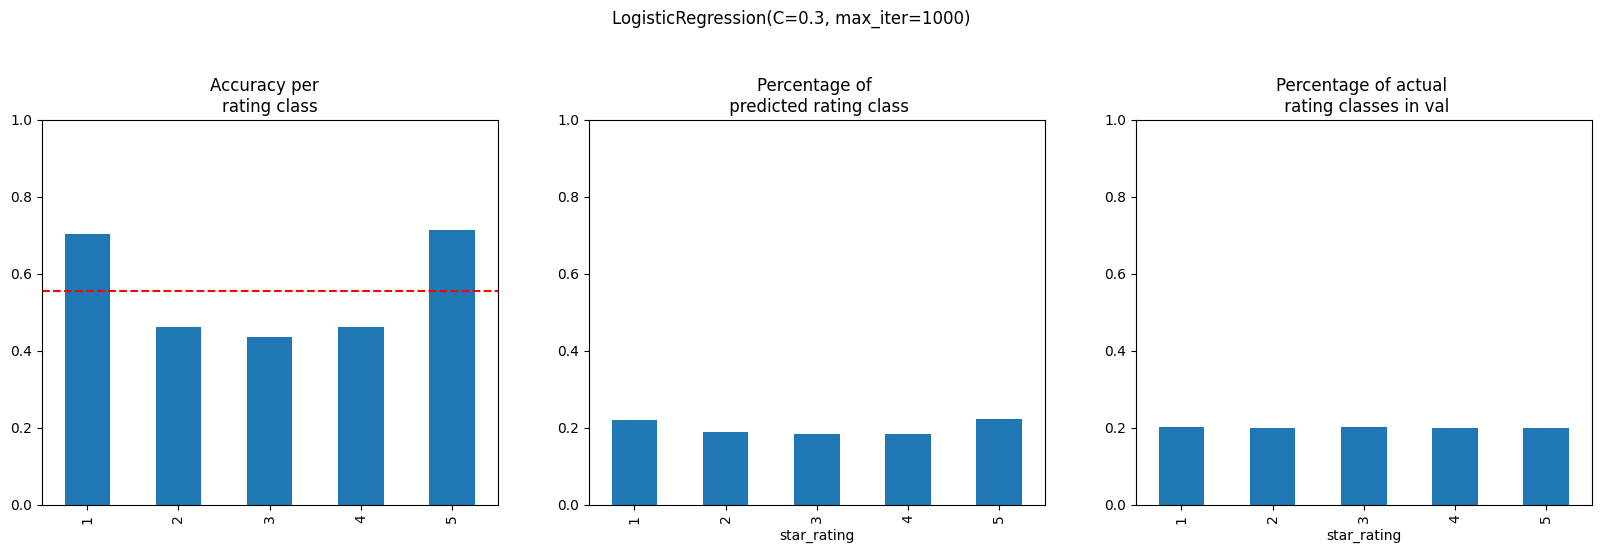

In [104]:
assess_on_val(best_pipe, X_val, y_val);

## Gridsearch

In [105]:
hyperparameter_grid = {
    'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3,0.5,0.75,1],
    #'vect__ngram_range': [(1,1),(1, 2),(1,3),(2,3)], 
    'vect__min_df': [0.0001],
    'vect__max_df' : [0.075, 0.1, 0.125],        
}
vectorizer_params = dict(ngram_range=(1, 3), min_df=0.0001, max_df=0.35-0.25)

grid_cv = GridSearchCV(estimator=pipeline,
            param_grid=hyperparameter_grid,
            cv=4,             
            scoring = 'accuracy', # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
            n_jobs = -1,
            verbose = 1, 
            return_train_score = True)

grid_cv.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_df=0.35,
                                                        min_df=0.001,
                                                        ngram_range=(1, 3))),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        LogisticRegression(C=0.5,
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3, 0.5, 0.75, 1],
                         'vect__max_df': [0.075, 0.1, 0.125],
                         'vect__min_df': [0.0001]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
# Result of GridSearchCV for LR
# GridSearchCV
# GridSearchCV(cv=4,
#              estimator=Pipeline(steps=[('vect',
#                                         CountVectorizer(max_df=0.35,
#                                                         min_df=0.001,
#                                                         ngram_range=(1, 3))),
#                                        ('tfidf', TfidfTransformer()),
#                                        ('clf',
#                                         LogisticRegression(C=0.5,
#                                                            max_iter=1000))]),
#              n_jobs=-1,
#              param_grid={'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3, 0.5, 0.75, 1],
#                          'vect__max_df': [0.075, 0.1, 0.125],
#                          'vect__min_df': [0.0001]},
#              return_train_score=True, scoring='accuracy', verbose=1)

In [106]:
best_pipe = grid_cv.best_estimator_
best_pipe

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.1, min_df=0.0001,
                                 ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=0.5, max_iter=1000))])

In [107]:
best_pipe.score(X_val, y_val)

0.5735975752585516

Start predicting
Finished predicting
Global accuracy: 0.5735975752585516


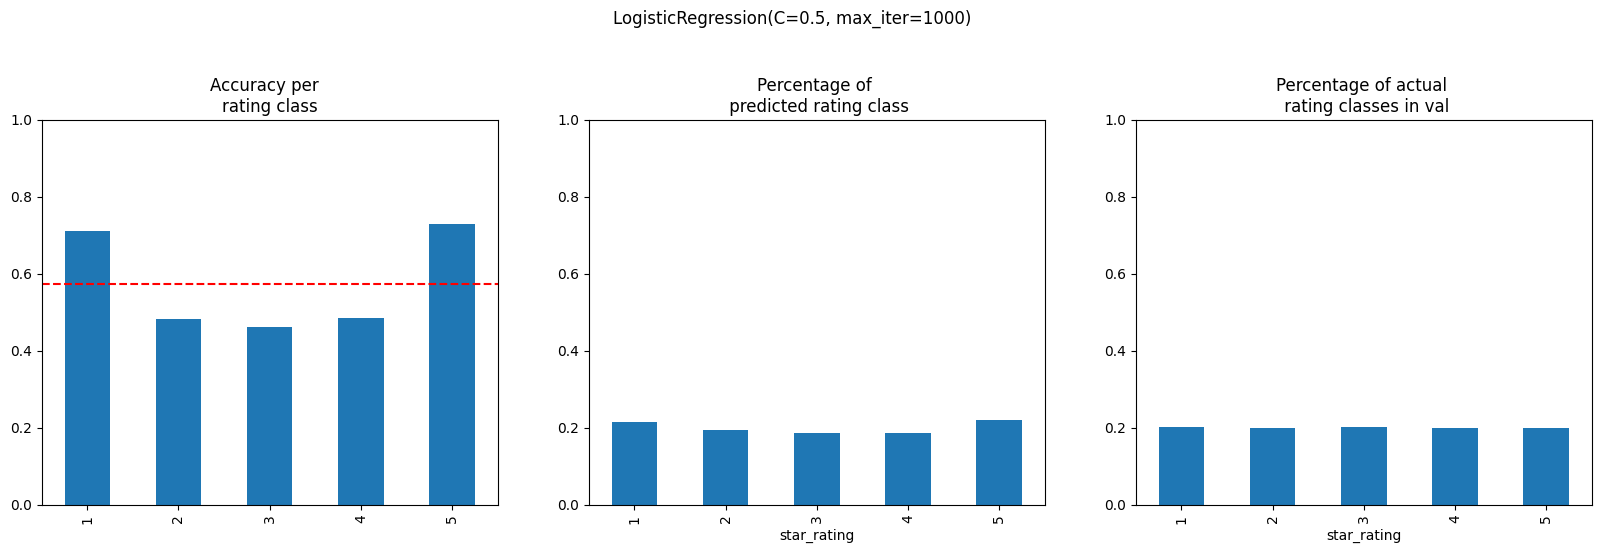

In [108]:
assess_on_val(best_pipe, X_val, y_val);

In [ ]:
import optuna 
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    """return the f1-score"""

    # search space
    n_estimators =  trial.suggest_int('n_estimators', low=100, high=200, step=50)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    min_samples_split = trial.suggest_int('min_samples_split', low=2, high=4, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', low=1, high=5, step=1)
    max_depth = trial.suggest_int('max_depth', low=5, high=7, step=1)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])

    # random forest classifier object
    rfc = RandomForestClassifier(n_estimators=n_estimators, 
                                                  criterion=criterion,
                                                  min_samples_split=min_samples_split,
                                                  min_samples_leaf=min_samples_leaf,
                                                  max_depth=max_depth,
                                                  max_features=max_features,
                                                  random_state=42)
    score =  cross_val_score(estimator=rfc, 
                             X=X_train, 
                             y=y_train, 
                             scoring='f1_micro',
                             cv=5,
                             n_jobs=-1).mean()
    
    return score

# create a study (aim to maximize score)
study = optuna.create_study(sampler=TPESampler(), direction='maximize')

# perform hyperparamter tuning (while timing the process)
time_start = time.time()
study.optimize(objective, n_trials=100)
time_bayesian = time.time() - time_start

# store result in a data frame 
values_bayesian = [100, study.best_trial.number, study.best_trial.value, time_bayesian]
results_bayesian = pd.DataFrame([values_bayesian], columns = columns)

In [ ]:
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score


# -- Define the objective function
def objective(trial):
    # -- Instantiate scaler
    # (a) List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    # -- Instantiate dimensionality reduction
     # (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 2, 30) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'

    # -- Instantiate estimator model
    knn_n_neighbors=trial.suggest_int("knn_n_neighbors", 1, 19, 2) # suggest an integer from 1 to with step 2
    knn_metric=trial.suggest_categorical("knn_metric", ['euclidean', 'manhattan', 'minkowski'])
    knn_weights=trial.suggest_categorical("knn_weights", ['uniform', 'distance'])

    estimator=KNeighborsClassifier(n_neighbors=knn_n_neighbors, metric=knn_metric, weights=knn_weights)

    # SW
    lr_params = dict(C=0.5, max_iter=1000)
    vectorizer_params = dict(ngram_range=(1, 3), min_df=0.00, max_df=0.35)#, max_features=10000) # 0.001 performs good and reduces runtime
    tfidf_params = dict(norm='l2')
    varth_params = dict(threshold=0.00005/100)
    percth_params = dict(score_func= selpc_fun, percentile = 95)
    # Supervised Pipeline




    lr_steps = [ ("vect", CountVectorizer(**vectorizer_params)),
            ("tfidf", TfidfTransformer(**tfidf_params)),
            #("percth", SelectPercentile(**percth_params)),
            #("varth", VarianceThreshold(**varth_params)),
            ("clf", LogisticRegression(**lr_params))]

    pipeline = Pipeline(lr_steps)

    #SW
    
    # -- Make a pipeline
    pipeline = make_pipeline(scaler, dimen_red_algorithm, estimator)

    # -- Evaluate the score by cross-validation
    score = cross_val_score(pipeline, X_train, y_train, scoring='f1')
    f1 = score.mean() # calculate the mean of scores
    return f1

study = optuna.create_study(direction="maximize") # maximise the score during tuning
study.optimize(objective, n_trials=100) # run the objective function 100 times

print(study.best_trial) # print the best performing pipeline

## Results after parameter finetuning

In [ ]:
lr_params = dict(C=0.5, max_iter=1000)
vectorizer_params = dict(ngram_range=(1, 3), min_df=0.001, max_df=0.35)#, max_features=10000) # 0.001 performs good and reduces runtime
tfidf_params = dict(norm='l2')
word2vec_params = dict(min_count=1, window = 5)
#percth_params = dict(score_func= selpc_fun, percentile = 95)
# Supervised Pipeline

lrw2v_steps = [ ("vect", W2VTransformer(**word2vec_params)),
        #("tfidf", TfidfTransformer(**tfidf_params)),
        #("percth", SelectPercentile(**percth_params)),
        #("varth", VarianceThreshold(**varth_params)),
        ("clf", LogisticRegression(**lr_params))]

pipeline = Pipeline(lrw2v_steps)

pipeline.fit(X_train, y_train)

KeyError: "word 'got game christma gift much anticip great workout huge ufc fan workout time natur thought would great option unfortun think far mani break move far slow like hard break sweat realli friend let play kinda thing ask fun challeng workout slightest' not in vocabulary"

In [95]:
pd.DataFrame(pipeline.get_params().keys())

0
0                   memory
1                    steps
2                  verbose
3                     vect
4                    tfidf
5                      clf
6           vect__analyzer
7             vect__binary
8       vect__decode_error
9              vect__dtype
10          vect__encoding
11             vect__input
12         vect__lowercase
13            vect__max_df
14      vect__max_features
15            vect__min_df
16       vect__ngram_range
17      vect__preprocessor
18        vect__stop_words
19     vect__strip_accents
20     vect__token_pattern
21         vect__tokenizer
22        vect__vocabulary
23             tfidf__norm
24       tfidf__smooth_idf
25     tfidf__sublinear_tf
26          tfidf__use_idf
27                  clf__C
28       clf__class_weight
29               clf__dual
30      clf__fit_intercept
31  clf__intercept_scaling
32           clf__l1_ratio
33           clf__max_iter
34        clf__multi_class
35             clf__n_jobs
36            clf__penalty
37       clf__random_state
38             clf__solver
39                clf__tol
40            clf__verbose
41         clf__warm_start

In [71]:
pd.DataFrame.from_dict(lr_pipeline.steps[0][1].vocabulary_, orient="index").reset_index().sort_values(by=0)

index     0
2207       aa     0
1219      aaa     1
343   abandon     2
1635     abil     3
44        abl     4
...       ...   ...
2095      zip  3411
770     zombi  3412
2235     zone  3413
2326     zoom  3414
2808    zumba  3415

[3416 rows x 2 columns]

In [99]:
dict(zip(feature_names.ravel() , X_train_vectorized.mean(axis=1))) 
#stopwrods: xbox, nintendo, game, amazon, christma, gamecub, im, mario, around, basketbal

{'aa': matrix([[0.00034342]]),
 'aaa': matrix([[0.00059032]]),
 'ab': matrix([[0.00056063]]),
 'abacus': matrix([[0.00032889]]),
 'abandon': matrix([[0.00041731]]),
 'abba': matrix([[0.00022538]]),
 'abc': matrix([[0.00030099]]),
 'abd': matrix([[0.0004535]]),
 'abe': matrix([[0.00020932]]),
 'abil': matrix([[0.00026331]]),
 'abilit': matrix([[0.00029385]]),
 'abit': matrix([[0.00039747]]),
 'abl': matrix([[0.00049444]]),
 'abnorm': matrix([[0.00059856]]),
 'abomin': matrix([[0.00100907]]),
 'abort': matrix([[0.00063437]]),
 'abound': matrix([[0.00019273]]),
 'abras': matrix([[0.00037401]]),
 'abroad': matrix([[0.0004026]]),
 'abrupt': matrix([[0.00032712]]),
 'absenc': matrix([[0.00089944]]),
 'absent': matrix([[0.00090666]]),
 'absolut': matrix([[0.00101455]]),
 'absolutley': matrix([[0.00020835]]),
 'absorb': matrix([[0.00046401]]),
 'abstract': matrix([[0.00028085]]),
 'absurd': matrix([[0.00121324]]),
 'abt': matrix([[0.00052331]]),
 'abund': matrix([[0.00038551]]),
 'abus': matri

# Classification

In [46]:
clf_mnNB = MultinomialNB().fit(X_train_vectorized, y_train)
clf_knn = KNeighborsClassifier(n_neighbors=40).fit(X_train_vectorized, y_train)
clf_lr = LogisticRegression(max_iter=1000).fit(X_train_vectorized, y_train)
clf_lr_L2_05 = LogisticRegression( C=0.5,max_iter=1000).fit(X_train_vectorized, y_train)
clf_lr_L1_05 = LogisticRegression(penalty="l1", C=0.25,max_iter=1000, solver= "saga").fit(X_train_vectorized, y_train)
clf_xgb = xgb.XGBClassifier(base_score=0.2, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5,
              max_delta_step=0, max_depth=20, min_child_weight=1,# missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)



# Appendix

In [45]:
# Assessement of results
# Add vine flag as feature!

In [35]:
#metrics.accuracy_score(predicted[y_val==rc], y_val[y_val==rc])

Start predicting
Finished predicting
Global accuracy: 0.4617830777967064


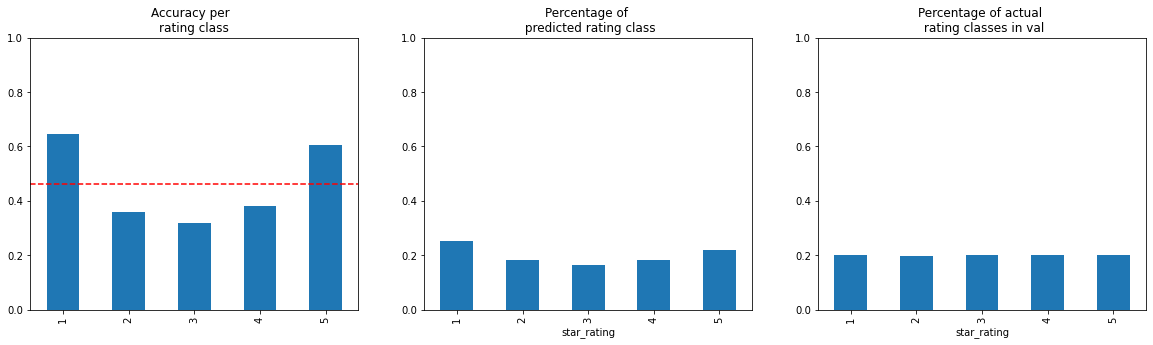

In [47]:
assess_on_val(clf_mnNB, X_val_vectorized, y_val)

Start predicting
Finished predicting
Global accuracy: 0.49646507666098805


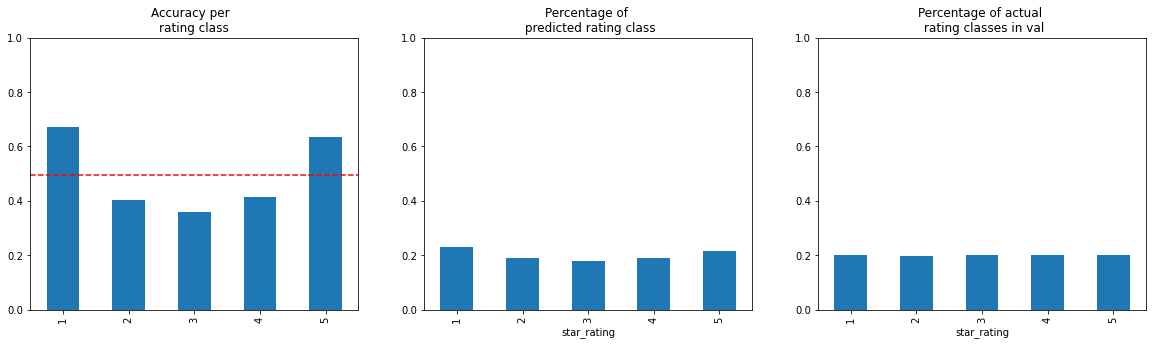

In [36]:
# New sample
assess_on_val(clf_lr_L2_05, X_val_vectorized, y_val);

In [46]:
clf_lr_L2_05.score(X_val_vectorized, y_val)

0.49646507666098805

Start predicting
Finished predicting
Global accuracy: 0.5043441226575809


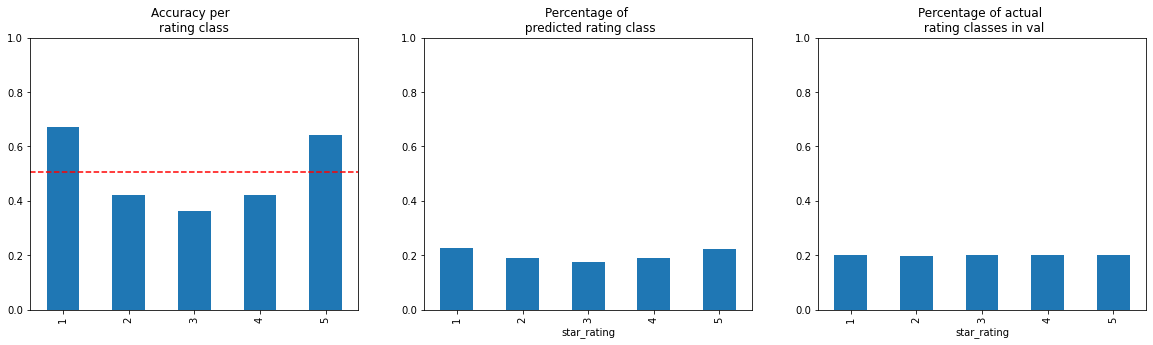

In [106]:
assess_on_val(clf_lr_L2_05, X_val_vectorized, y_val);

Start predicting
Finished predicting
Global accuracy: 0.49622373651334467


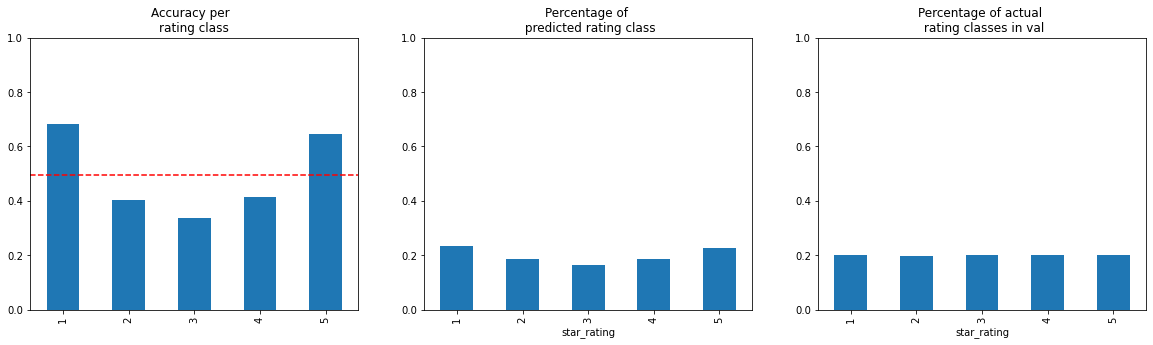

In [105]:
assess_on_val(clf_lr_L1_05, X_val_vectorized, y_val);

In [95]:
#Analyse words predicting class 0
coefs = pd.DataFrame.from_dict({"coef": clf_lr_L2_05.coef_[0,:], "feature": feature_names.ravel()}, orient="index")
coefs = coefs.transpose()
coefs["abs_coef"]=np.abs(coefs.coef)
coefs.sort_values(by="abs_coef", ascending=False).head(40)

coef     feature  abs_coef
2663  -6.34947       great   6.34947
6921  6.003601       worst  6.003601
6764  5.691694        wast  5.691694
6136  5.129915     terribl  5.129915
3605 -4.973701        love  4.973701
2931  4.359777     horribl  4.359777
5092   4.23451      return   4.23451
1609  4.134234  disappoint  4.134234
4424 -4.101356     perfect  4.101356
2479  4.002121      garbag  4.002121
540  -3.994098        best  3.994098
4578  3.877165        poor  3.877165
2418 -3.841276         fun  3.841276
392  -3.736629      awesom  3.736629
1772  3.723408         drm  3.723408
2598 -3.643766        good  3.643766
3904  3.561819       money  3.561819
4079 -3.549802        nice  3.549802
3312  3.534719        junk  3.534719
2015  3.525487        even  3.525487
384   3.475898          aw  3.475898
4289 -3.378695      overal  3.378695
2041 -3.216886       excel  3.216886
578  -3.171486         bit  3.171486
6194 -3.141913      though  3.141913
383   3.029937       avoid  3.029937
1831   2.91977          ea   2.91977
6352   2.90989       trash   2.90989
179  -2.899537        amaz  2.899537
6586  2.852078     useless  2.852078
6920  2.834552        wors  2.834552
3552 -2.833531       littl  2.833531
1300  2.808448        crap  2.808448
5959   2.79621        suck   2.79621
4958  2.787174      refund  2.787174
65   -2.762473      addict  2.762473
2141 -2.699301     fantast  2.699301
1154 -2.675159   complaint  2.675159
3038   2.66813      imposs   2.66813
1951 -2.657773       enjoy  2.657773

coef  feature
1069 -6.373212    great
1416 -5.001928     love
1748 -4.128307  perfect
221    -4.0107     best
990  -3.869566      fun
...        ...      ...
2014  4.254924   return
1172  4.397509  horribl
2430   5.17903  terribl
2661  5.757634     wast
2726   6.07725    worst

[2779 rows x 2 columns]

Start predicting
Finished predicting
Global accuracy: 0.5320414537194775


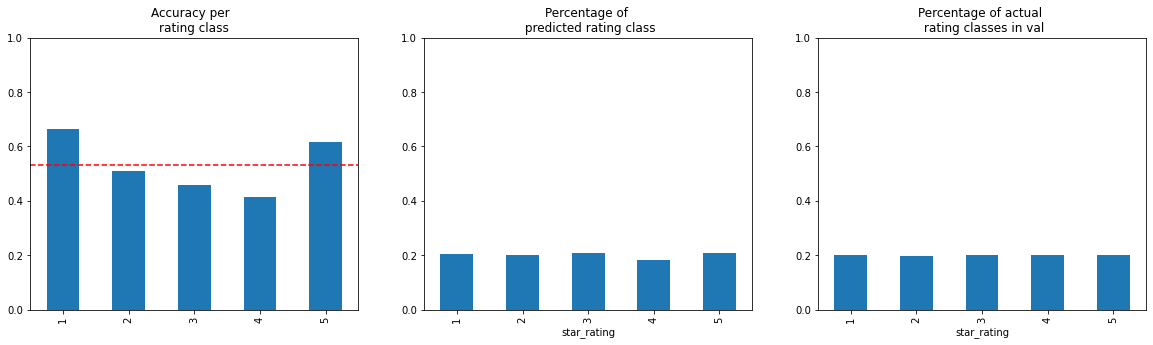

In [109]:
assess_on_val(clf_xgb, X_val_vectorized, y_val);
# 10000 features (/10 for variance threshold)

Start predicting
Finished predicting
Global accuracy: 0.5330777967064169


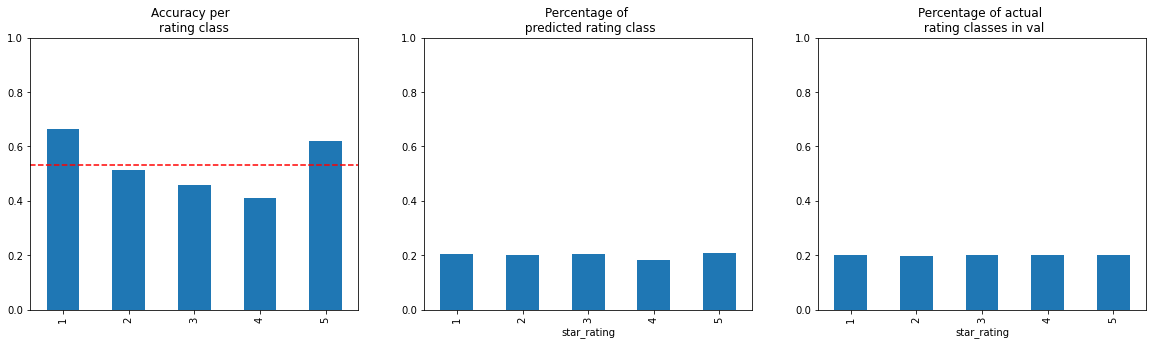

In [114]:
assess_on_val(clf_xgb, X_val_vectorized, y_val);
#/2 => 4000 features

Start predicting
Finished predicting
Global accuracy: 0.5342703009653605


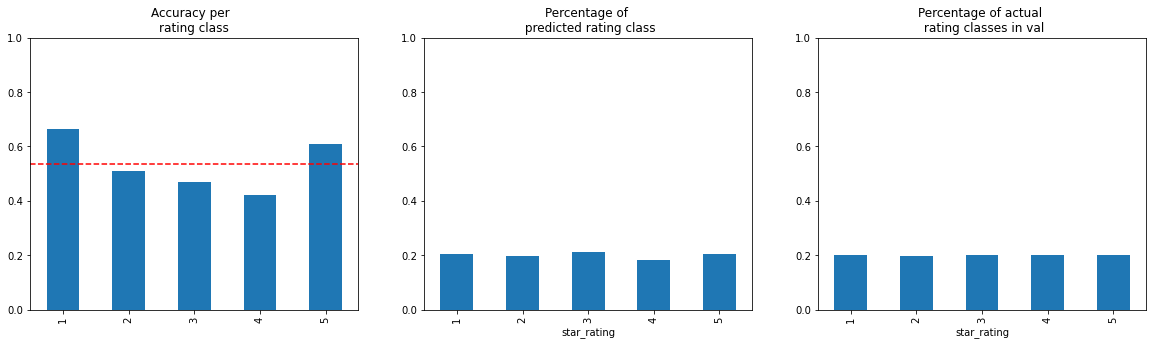

In [121]:
assess_on_val(clf_xgb, X_val_vectorized, y_val);
#1 

# Reference

In [131]:
# Reference for w2v
# https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794